# Algortimos genéticos

Optimización de parámetros de Support Vector Machine con Kernel Gaussiano para una tarea de clasificación.

In [1]:
import pandas as pd
import numpy as np
import glob
import xml.etree.ElementTree as ET
from gensim.models import Doc2Vec
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import nltk
from sklearn.cross_validation import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier

from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import f1_score as f1
from sklearn import cross_validation

from bitarray import bitarray
import math
import random

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
path_prep_files = 'Training/' # 2-way scientist dataset (trainning)
all_files =  glob.glob(path_prep_files+'*.xml')
print (len(all_files))


135


In [3]:
_fname = "/home/aecarrillor/ASAG/GoogleNews-vectors-negative300.bin"
w2vModel = Doc2Vec.load_word2vec_format(_fname, binary=True)

In [4]:
# crear array con id de pregunta, textos combinados y calificación.

id_question=[]# Identificador de la pregunta (etiqueta de clase).
calif=[]# Marca de criterio.
quest=[]#Pregunta.
ref_answer=[]#Respuesta de referencia.
stud_answ=[]#Respuesta de estudiante.


for doc in all_files:
    tree = ET.parse(doc)
    root = tree.getroot()
    question=root[0].text
    grade_st=[branch.attrib["accuracy"] for branch in root[2]]
    answers_st=[branch.text for branch in root[2]]
    answers_ref=[branch.text for branch in root[1]]# If there are more of 1 reference answer...
    for ith_ans,st_answ in enumerate(answers_st):
        quest.append(question)
        ref_answer.append(answers_ref[0])
        stud_answ.append(st_answ)
        id_question.append(root.attrib["id"])
        st_ans_calif=str(grade_st[ith_ans])
        calif.extend([1 if st_ans_calif=="correct" else 0])

In [5]:
def w2vec_txts(txts):
    return np.array([(sum([w2vModel[word.lower()] for word in nltk.word_tokenize(StAns) if word.lower() in w2vModel ])/
                       len([w2vModel[word.lower()] for word in nltk.word_tokenize(StAns) if word.lower() in w2vModel])) 
                       for StAns in txts])

In [6]:
w2v_questions=w2vec_txts(quest)
w2v_RefAns=w2vec_txts(ref_answer)
w2v_StudAns=w2vec_txts(stud_answ)

In [7]:
Preg_RefAns_StAns=[]
for i in xrange(len(w2v_questions)):
    vec_900=[]
    vec_900.extend(w2v_questions[i])
    vec_900.extend(w2v_RefAns[i])
    vec_900.extend(w2v_StudAns[i])
    Preg_RefAns_StAns.append(vec_900)

In [8]:
# #split data
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v= train_test_split(Preg_RefAns_StAns,calif, test_size=0.25, random_state=42)

In [9]:
# Clasificador lineal optimizado con stochastic gradient descent.
svc = SGDClassifier(loss="hinge", penalty="l2", n_iter=1500)
svc.fit(X_train_w2v, y_train_w2v)
yhat = svc.predict(X_test_w2v)
f1_eval_w2v=f1(y_test_w2v, yhat)

In [10]:
f1_eval_w2v

0.58265895953757219

In [11]:
# Clasificador Kernel Gaussiano.
svr = svm.SVC(kernel='rbf')
svr.fit(X_train_w2v, y_train_w2v)
y_est = svr.predict(X_test_w2v)
f1_svr=f1(y_test_w2v, y_est)
print ("parámetros default", f1_svr)

('par\xc3\xa1metros default', 0.0)


/opt/anaconda/envs/mindlabenv/lib/python2.7/site-packages/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
cods=range(-1024,1024)
C_param_vals=[10**(val/100.0) for val in cods]
print("len=",len(C_param_vals),"min",min(C_param_vals),"max",max(C_param_vals),"med",C_param_vals[1024])
len(C_param_vals)
sigma_param_vals=[3**(val/100.0) for val in cods]
print("len",len(sigma_param_vals),"min",min(sigma_param_vals),"max",max(sigma_param_vals),"med",sigma_param_vals[1024])


('len=', 2048, 'min', 5.7543993733715666e-11, 'max', 16982436524.61746, 'med', 1.0)
('len', 2048, 'min', 1.3010031607552597e-05, 'max', 76023.95090247074, 'med', 1.0)


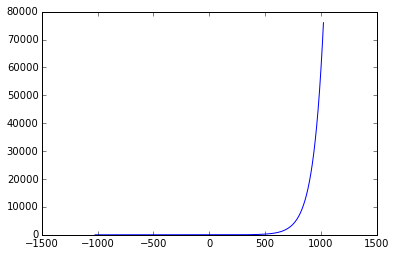

In [13]:
#plt.figure(figsize=(15,8))
base_seq=range(-1024, 1024)
#plt.plot(cods,C_param_vals)
plt.plot(cods,sigma_param_vals)
plt.show()

# Funciones

In [ ]:
def pop_indiv(bit_len=22):
    return ''.join([str(random.randint(0,1))for i in range(bit_len)])
    #return ''.join(['1' if bit==True else '0' for bit in bitarray(bit_len)])

def decode_indiv(indiv):
    c_param=10**((int(indiv[:11],2)-1024)/100.0)
    sigma_param= 3**((int(indiv[11:],2)-1024)/100.0)
    return [c_param, sigma_param]

def fit_SVGauss(individuo):
    c_param_bit=10**((int(indivuo[:11],2)-1024)/100.0)
    sigma_param_bit= 3**((int(indivuo[11:],2)-1024)/100.0)    
    svg = svm.SVC(kernel='rbf', C=c_param_bit, gamma=sigma_param_bit)
    svg.fit(X_train_w2v, y_train_w2v)
    y_est = svg.predict(X_test_w2v)
    f1_svr=f1(y_test_w2v, y_est, average='weighted')
    return f1_svr

def svg_2(indiv):
    #decode_indiv(indiv)
    svr = svm.SVC(kernel='rbf', C=decode_indiv(indiv)[0], gamma=decode_indiv(indiv)[1])
    svr.fit(X_train_w2v, y_train_w2v)
    y_est = svr.predict(X_test_w2v)
    f1_svr=f1(y_test_w2v, y_est, average='weighted')
    return f1_svr

def rastrigin(X_array, A=10, m=0):
    n=len(X_array)
    y=A*n+(sum([(x_val**2)-(A*math.cos(2*math.pi*x_val))for x_val in X_array]))
    return y

In [ ]:
popul_size=1000
population_1=[pop_indiv() for i in range(popul_size)]
rastr=[rastrigin(decode_indiv(ind)) for ind in population_1]
svg_fit=[svg_2(ind) for ind in population_1]
decods=[decode_indiv(ind) for ind in population_1]

In [ ]:
print("Population",np.array(population_1))
print ("decods",np.array(decods))
print ("Rastrig",np.array(rastr))
print ("svg_fit",np.array(svg_fit))

plt.figure(figsize=(15,8))
plt.plot(svg_fit)

In [ ]:
import csv
#print ("decods",np.array(decods))
writer = csv.writer(open("params_2.csv", 'w'))
for i in range(len(svg_fit)):
    #if counter[row[0]] >= 4:
    writer.writerow([decods[i],svg_fit[i]])


In [ ]:
plt.figure(figsize=(15,8))
plt.hist(svg_fit)

# Test_Code


In [ ]:
print (len(decods))
print (len (svg_fit))
print (max(svg_fit))

(5.623413251903491, 6.6899022280750415, 0.74872838250254325)


In [30]:
#c_param=10**((int(indiv[:11],2)-1024)/100.0)
#sigma_param= 3**((int(indiv[11:],2)-1024)/100.0)
def fit_SVGauss(individuo):
    c_param_bit=10**((int(indivuo[:11],2)-1024)/100.0)
    sigma_param_bit= 3**((int(indivuo[11:],2)-1024)/100.0)    
    svr = svm.SVC(kernel='rbf', C=c_param_bit, gamma=sigma_param_bit)
    svr.fit(X_train_w2v, y_train_w2v)
    y_est = svr.predict(X_test_w2v)
    f1_svr=f1(y_test_w2v, y_est, average='weighted')
    return f1_svr

In [131]:
c_best=5.623413251903491
gamma_best=6.6899022280750415
svg_fit_best=0.74872838250254325

In [ ]:
2048**2

In [104]:
def svg_2(indiv):
    #decode_indiv(indiv)
    svr = svm.SVC(kernel='rbf', C=decode_indiv(indiv)[0], gamma=decode_indiv(indiv)[1])
    svr.fit(X_train_w2v, y_train_w2v)
    y_est = svr.predict(X_test_w2v)
    f1_svr=f1(y_test_w2v, y_est, average='weighted')
    return f1_svr


In [105]:
svg_2(indiv)

0.60735468564650053